Today, I'm going to be discussing the difference between two volatility estimators.

# The Data

----


I'm going to be using daily-resolution SPX data from [Sharadar](https://www.quandl.com/publishers/SHARADAR) as well as minute-resolution SPX data from [First Rate Data](https://firstratedata.com/).

In [136]:
import pandas as pd
import numpy as np
import sqlite3
from matplotlib import pyplot as plt
from scipy import stats

# Set default figure size
plt.rcParams["figure.figsize"] = (15, 10)

In [172]:
conn = sqlite3.Connection("data.db")

spx_daily = pd.read_sql("SELECT * FROM prices WHERE ticker='^GSPC'", conn, index_col="date", parse_dates=["date"])
spx_minute = minute = pd.read_csv("SPX_1min.csv", header=0,names=['datetime', 'open', 'high', 'low', 'close'],
                                  index_col='datetime', parse_dates=True)

In [13]:
# A quick look at the data
spx_daily.head()

,ticker,open,high,low,close,volume,dividends,closeunadj,lastupdated
date,,,,,,,,,
1997-12-31,^GSPC,970.84,975.02,967.41,970.43,467280000,0,970.43,2019-02-03
1998-01-02,^GSPC,970.43,975.04,965.73,975.04,366730000,0,975.04,2019-02-03
1998-01-05,^GSPC,975.04,982.63,969.00,977.07,628070000,0,977.07,2019-02-03
1998-01-06,^GSPC,977.07,977.07,962.68,966.58,618360000,0,966.58,2019-02-03
1998-01-07,^GSPC,966.58,966.58,952.67,964.00,667390000,0,964.00,2019-02-03


In [14]:
spx_minute.head()

,open,high,low,close
datetime,,,,
2007-04-27 12:25:00,1492.39,1492.54,1492.39,1492.54
2007-04-27 12:26:00,1492.57,1492.57,1492.52,1492.56
2007-04-27 12:27:00,1492.58,1492.64,1492.58,1492.63
2007-04-27 12:28:00,1492.63,1492.73,1492.63,1492.73
2007-04-27 12:29:00,1492.91,1492.91,1492.87,1492.87


# The Estimators

---


Now, what I want to do is compare volatility estimates from these two data sets. I would prefer to use the daily data if possible, because in my case it's easier to get and updates more frequently.

### Garman-Klass Estimator

This estimator has been around for a while and is deemed to be far more effcient than a traditional close-to-close volatility estimator (Garman and Klass, 1980).

From equation 20 in the paper, a jump adjusted volatility estimator:

$ f = 0.73 $, percentage of the day trading is closed based on NYSE hours of 9:30 to 4

$ a = 0.12 $, as they suggest in the paper

$ \sigma^2_{unadj} = 0.511(u - d)^2 - 0.019(c(u+d) - 2ud) - 0.383c^2 $

$ \sigma^2_{adj} = 0.12\frac{(O_{1} - C_{0})^2}{0.73} + 0.12\frac{\sigma^2_{unadj}}{0.27}$

Where,

$ u = H_{1} - O_{1} $, the normalized high

$ d = L_{1} - O_{1} $, the normalized low

$ c = C_{1} - O_{1} $, the normalized close

and subscripts indicating time. They also indicate in the paper that these equations expect the log of the price series.

In [61]:
def gk_vol_calc(data):
    u = np.log(data['high']) - np.log(data['open'])
    d = np.log(data['low']) - np.log(data['open'])
    c = np.log(data['close']) - np.log(data['open'])
    vol_unadj = 0.511 * (u - d)**2 - 0.019 * (c * (u + d) - 2 * u * d) - 0.283 * c**2
    
    jumps = np.log(data['open']) - np.log(data['close'].shift(1))
    vol_adj = 0.12 * (jumps**2 / 0.73) + 0.12 * (vol_unadj / 0.27)
    
    return vol_adj

<AxesSubplot:xlabel='date'>

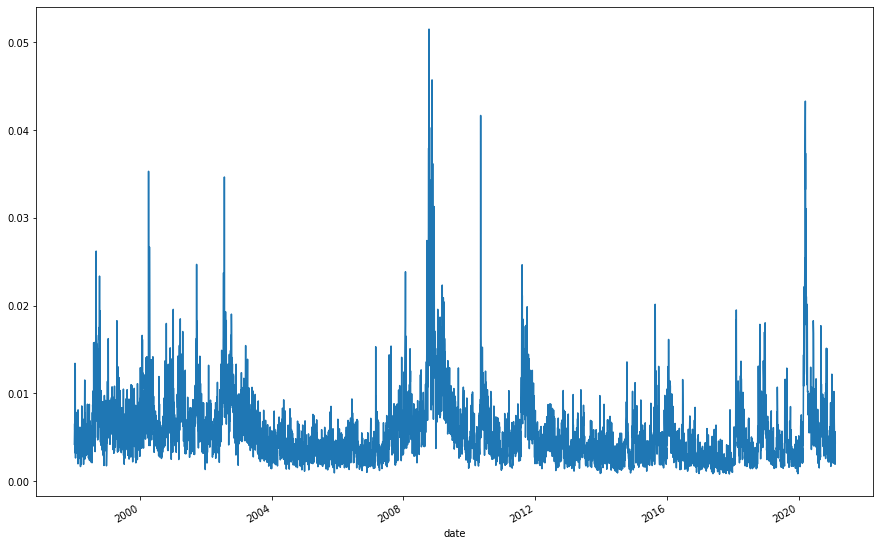

In [62]:
# Let's take a look
gk_vol = np.sqrt(gk_vol_calc(spx_daily))
gk_vol.plot()

As an aside, opening jumps have become more common and larger in recent years, maybe something to investigate. This is as a percentage, so it's not a simple case of the index values becoming larger.

<AxesSubplot:xlabel='date'>

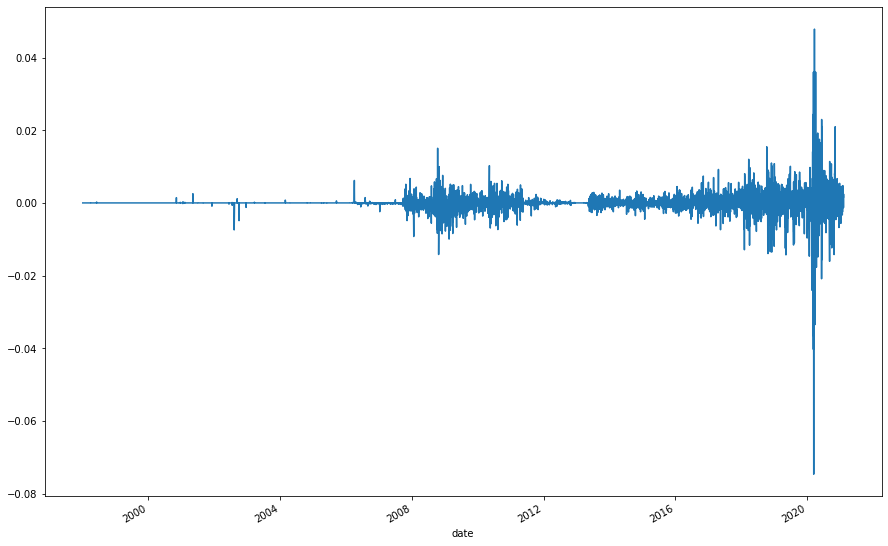

In [63]:
(spx_daily['open'] / spx_daily['close'].shift(1) - 1).plot()

### Realized Volatility Estimator

This estimator is very simply and has become more prominent in the literature in the last few years because of increasing availability of higher-frequency data. Based on (Liu, Patton, and Sheppard, 2012), it's hard to beat a 5-minute RV. Here, I'm going to use a 1-minute estimator, which is also shown to be effective.

$ RV_{t} = \sum_{k=1}^n r_{t,k}^2 $, where the $t$ index is each day, and the $k$ index represents each intraday return

For daily volatility, it's simply a sum of squared returns from within that day. So in this case we calculate returns for each 1 minute period, square them, and they sum them for each day.

In [64]:
def rv_calc(data):
    results = {}
    
    for idx, data in data.groupby(data.index.date):
        returns = np.log(data['close']) - np.log(data['close'].shift(1))
        results[idx] = np.sum(returns**2)
        
    return pd.Series(results)

<AxesSubplot:>

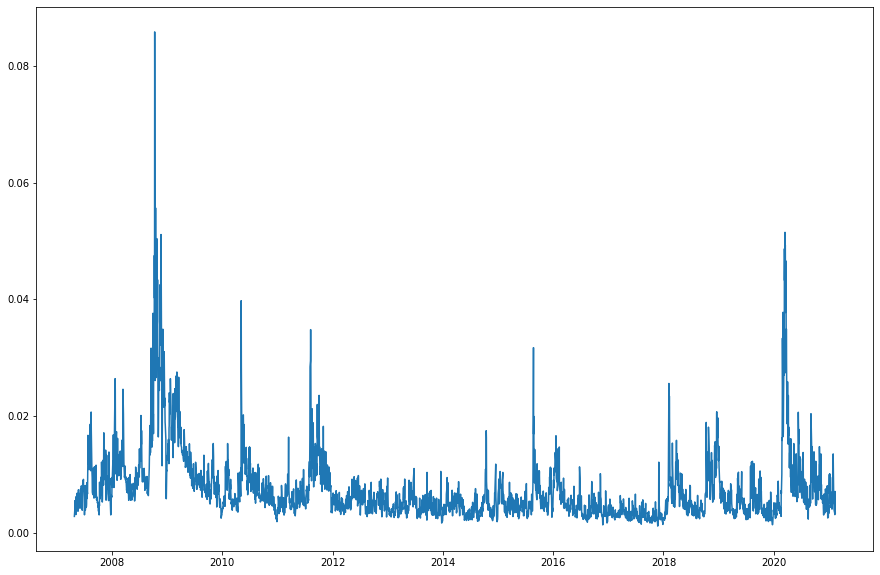

In [106]:
# Let's take a look at this one
rv = np.sqrt(rv_calc(spx_minute))
rv.plot()

# Comparisons

---


In [83]:
# Because the minute data has a shorter history, let's match them up
gk_vol = gk_vol.reindex(rv.index)

<AxesSubplot:>

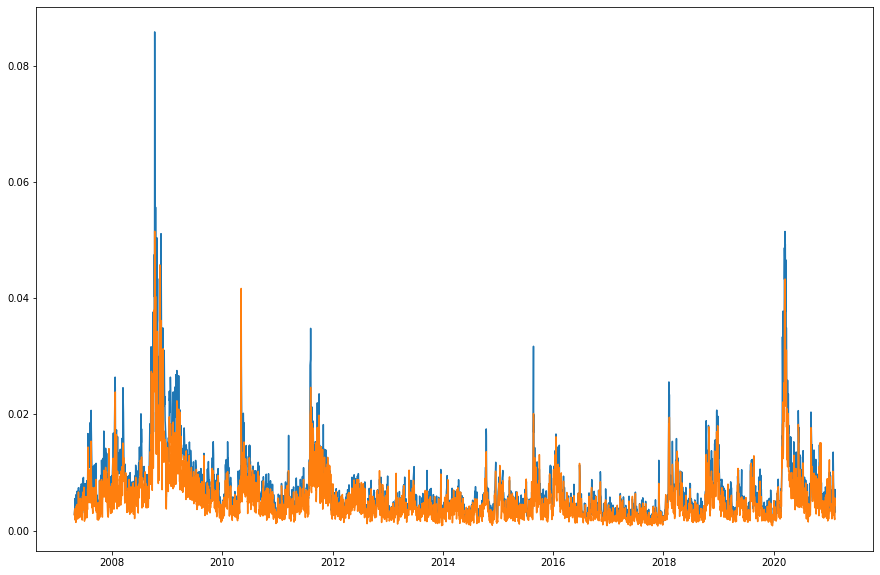

In [140]:
rv.plot()
gk_vol.plot()

Here's a plot of our two different volatility estimators with RV in blue and Garman-Klass in orange. The RV estimator is far less noisy, looking at each of their graphs above. The Garman-Klass estimator also seems to persistently return a lower result than RV. This is backed up by looking at a graph of their difference.

<AxesSubplot:>

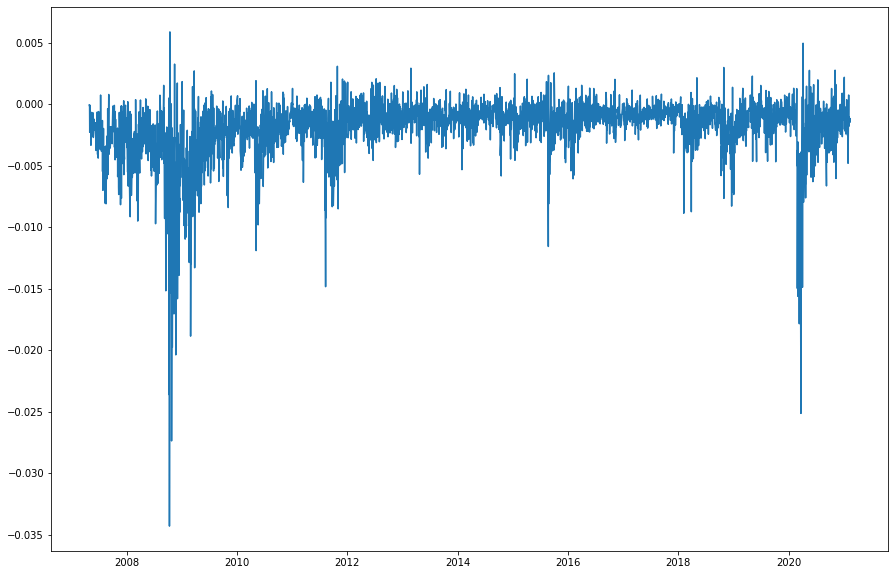

In [141]:
(gk_vol - rv).plot()

Netx, let's analyze how they do at normalizing the returns of the S&P 500. According to (Molnár, 2015) normalizing a number of equity returns by their Garman-Klass estimated volatility does indeed make their distributions normal. Let's see if we can replicate that result with either of our esimates on the S&P 500.

In [93]:
# Daily close-to-close returns of the S&P 500
spx_returns = np.log(spx_daily['close']) - np.log(spx_daily['close'].shift(1))
spx_returns = spx_returns.reindex(rv.index)

In [119]:
# Normalizing by our estimated volatilties
gk_vol_norm = (spx_returns / gk_vol).dropna()
rv_norm = (spx_returns / rv).dropna()

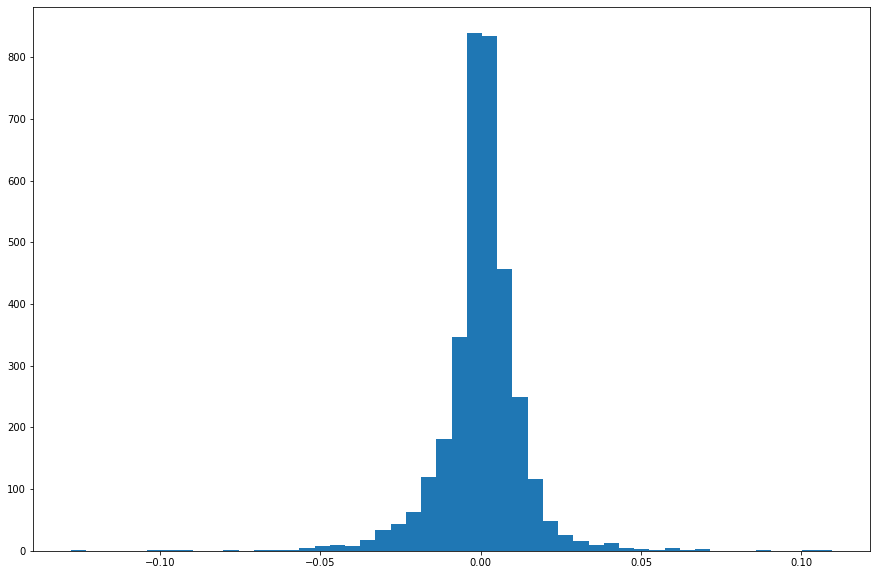

In [147]:
# Here are the unadjusted returns
_, _, _ = plt.hist(spx_returns, bins=50)

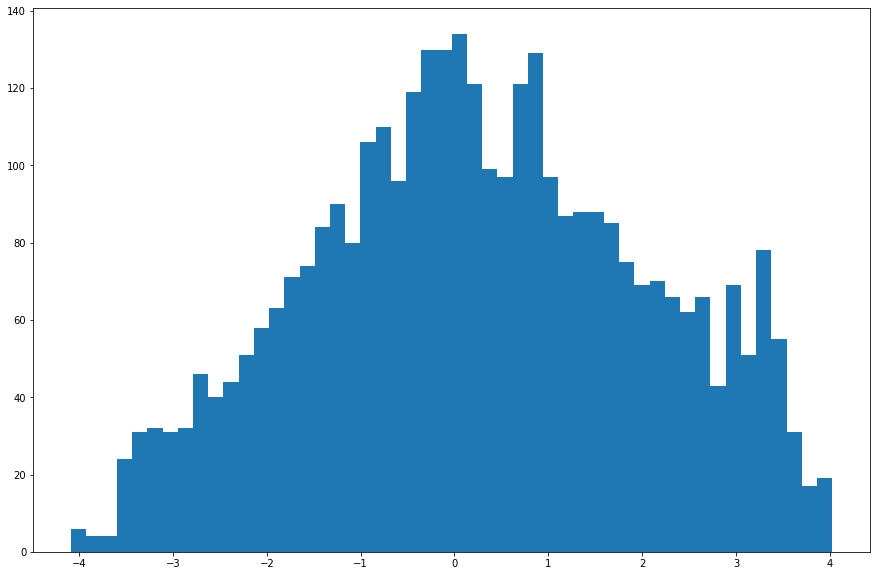

In [146]:
# Here's normalized by the Garman-Klass Estimator
_, _, _ = plt.hist(gk_vol_norm, bins=50)

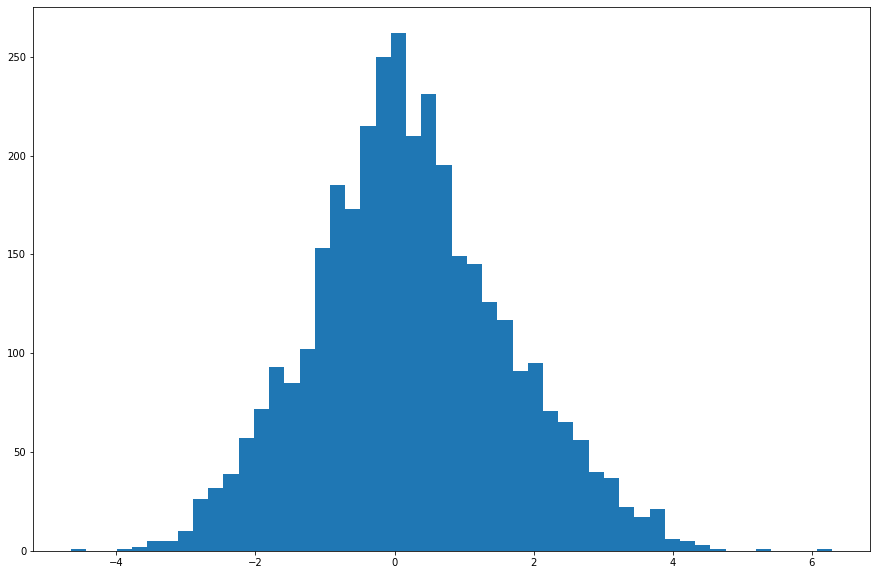

In [148]:
# And this is by the RV estimator
_, _, _ = plt.hist(rv_norm, bins=50)

At first glance, the RV adjusted returns seem most like normal to me, let's run some tests.

In [152]:
print(stats.skewtest(gk_vol_norm))
print(stats.skewtest(rv_norm))

SkewtestResult(statistic=-0.36471893389501464, pvalue=0.7153212235812803)
SkewtestResult(statistic=5.264134401424821, pvalue=1.4085138517604742e-07)


In [153]:
print(stats.kurtosistest(gk_vol_norm))
print(stats.kurtosistest(rv_norm))

KurtosistestResult(statistic=-13.090322527982106, pvalue=3.7401627016188313e-39)
KurtosistestResult(statistic=0.319898667029484, pvalue=0.7490451483769529)


Looks like the Garman-Klass-normalized returns have normal skew, but non-normal kurtosis. The RV-normalized returns have non-normal skwe but normal kurtosis! There's no winning here! Both are non-normal in different ways. Either normalization does do better than the unadjusted returns though.

In [158]:
print(stats.skewtest(spx_returns.dropna()))
print(stats.kurtosistest(spx_returns.dropna()))

SkewtestResult(statistic=-12.37783066245627, pvalue=3.445297267854248e-35)
KurtosistestResult(statistic=26.46472847776948, pvalue=2.46983337834253e-154)


# Conclusion

---


While from a statistical point of view, neither option seems particularly favorable, my personal choice is going to be the RV estimator. I think the literature is clear on its efficacy and its less noisy and conceptually easier. It's been said that when there are a bunch of competing theories, none of them are very good. So I'll pick the simplest option and go with RV.

# References

---


- Garman, M., & Klass, M. (1980). On the Estimation of Security Price Volatilities from Historical Data. The Journal of Business, 53(1), 67-78. Retrieved February 14, 2021, from http://www.jstor.org/stable/2352358


- Liu, L., Patton, A., &amp; Sheppard, K. (2012). Does Anything Beat 5-Minute RV? A Comparison of Realized Measures Across Multiple Asset Classes. SSRN. http://dx.doi.org/10.2139/ssrn.2214997


- Molnár, P. (2015). Properties of Range-Based Volatility Estimators. SSRN. Retrieved from https://ssrn.com/abstract=2691435